In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install openpyxl

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle as cPickle
import pandas as pd
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import Model
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional
from keras import regularizers
from openpyxl import Workbook

In [ ]:
path_data = "/content/drive/MyDrive/DP_OTG/data/"
path_model = "/content/drive/MyDrive/DP_OTG/Result/"
path_result = "/content/drive/MyDrive/DP_OTG/Result/"

In [ ]:
def twoTupleDic1():
    AA_list_sort = ['G','A','V','L','I','M','P','F','W','S','T','N','Q','Y','C','K','R','H','D','E','X']

    AA_dict = {}
    numm = 1
    for i in AA_list_sort:
        AA_dict[i] = numm
        numm += 1
    return AA_dict
def ProSentence(pro, K):
	sentence = ""
	length = len(pro)
	for i in range(length - K + 1):
		sentence += pro[i: i + K] + " "
    #delete extra space
	sentence = sentence[0 : len(sentence) - 1]
	return sentence
k =1#1-gram
word_index1 = twoTupleDic1()
vocab_size = len(word_index1)


In [ ]:
# Train data
file_train = "Training.csv"
df_train =pd.read_csv(path_data+file_train, delimiter= ',')

texts_train =[] #PTMsequend kmer
for i in df_train['Sequence']:
  temp = ProSentence(i,k)
  texts_train.append(temp)
df_train['k_mer'] =texts_train
train_sequences = []
for each in texts_train:
    each_index_list = []
    each = each.split(' ')
    for i in each:
        each_index_list.append(word_index1[i])
    train_sequences.append(each_index_list)
# Tokenizer train data
data_token = []
for i in df_train['k_mer']:
   data_token.append(i.split())
MAX_SEQUENCE_LENGTH = len(data_token[1])

Xtrain = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
ytrain = np.array(df_train['Label'])
ytrain = np.array(ytrain)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
ytrain= lb.fit_transform(ytrain)
ytrain = to_categorical(ytrain)
ytrain.shape

(1757, 2)

In [ ]:
max_sequence_length = MAX_SEQUENCE_LENGTH
INPUT_SIZE =300
vocab_size = 21

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, Input, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D,BatchNormalization, MaxPooling1D, Flatten, Concatenate, Embedding, Dropout, LayerNormalization, Dense, SpatialDropout1D, Bidirectional, LSTM

def create_model(vocab_size, max_sequence_length):
    inputs = Input(shape=(max_sequence_length,))
    embedding = Embedding(vocab_size + 1,300, input_length=max_sequence_length, trainable=True)(inputs)
    embedding = SpatialDropout1D(0.3)(embedding)  # Dropout chuyên biệt cho embeddings

    # CNN branch 1 (kernel size = 3)
    cnn1 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(embedding)
    cnn1 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn1)
    cnn1 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn1)
    cnn1 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn1)
    cnn1 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn1)
    cnn1 = MaxPooling1D(2)(cnn1)
    cnn1 = Dropout(0.4)(cnn1)
    cnn1 = BatchNormalization()(cnn1)

    # CNN branch 2 (kernel size = 5)
    cnn2 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(embedding)
    cnn2 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(cnn2)
    cnn2 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(cnn2)
    cnn2 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(cnn2)
    cnn2 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(cnn2)
    cnn2 = MaxPooling1D(2)(cnn2)
    cnn2 = Dropout(0.4)(cnn2)
    cnn2 = BatchNormalization()(cnn2)


    # CNN branch 3 (kernel size = 7)
    cnn3 = Conv1D(filters=32, kernel_size=7, activation='relu', padding='same')(embedding)
    cnn3 = Conv1D(filters=32, kernel_size=7, activation='relu', padding='same')(cnn3)
    cnn3 = Conv1D(filters=32, kernel_size=7, activation='relu', padding='same')(cnn3)
    cnn3 = Conv1D(filters=32, kernel_size=7, activation='relu', padding='same')(cnn3)
    cnn3 = Conv1D(filters=32, kernel_size=7, activation='relu', padding='same')(cnn3)
    cnn3 = MaxPooling1D(2)(cnn3)
    cnn3 = Dropout(0.4)(cnn3)
    cnn3 = BatchNormalization()(cnn3)

    # Bi-LSTM branch
    # Bi-LSTM branch
    lstm = Bidirectional(LSTM(32, return_sequences=True))(embedding)
    lstm = Dropout(0.4)(lstm)
    lstm = BatchNormalization()(lstm)
    lstm = Flatten()(lstm)  # Chuyển đầu ra Bi-LSTM thành vector

    # Concatenate CNN + Bi-LSTM outputs
    merged = Concatenate()([Flatten()(cnn1), Flatten()(cnn2), Flatten()(cnn3),lstm])
    dense1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(merged)
    dense1 = Dropout(0.5)(dense1)
    dense1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense1)
    dense1 = Dropout(0.5)(dense1)
    outputs = Dense(2, activation='softmax')(dense1)  # Binary classification

    model = Model(inputs, outputs)
    return model



In [ ]:
model= create_model(vocab_size, MAX_SEQUENCE_LENGTH)
# Compile the model
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 41)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 41, 300)        │          6,600 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d         │ (None, 41, 300)        │              0 │ embedding[0][0]        │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 41, 32)         │         28,832 │ spatial_dropout1d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 41, 32)         │         48,032 │ spatial_dropout1d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 41, 32)         │         67,232 │ spatial_dropout1d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 41, 32)         │          3,104 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 41, 32)         │          5,152 │ conv1d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 41, 32)         │          7,200 │ conv1d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 41, 32)         │          3,104 │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 41, 32)         │          5,152 │ conv1d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 41, 32)         │          7,200 │ conv1d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 41, 32)         │          3,104 │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 41, 32)         │          5,152 │ conv1d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 41, 32)         │          7,200 │ conv1d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 41, 32)         │          3,104 │ conv1d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 41, 32)         │          5,152 │ conv1d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 41, 32)         │          7,200 │ conv1d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 20, 32)         │              0 │ conv1d_4[0][0]         │
│ (MaxPooling1D)       

 Total params: 888,554 (3.39 MB)

 Trainable params: 888,234 (3.39 MB)

 Non-trainable params: 320 (1.25 KB)

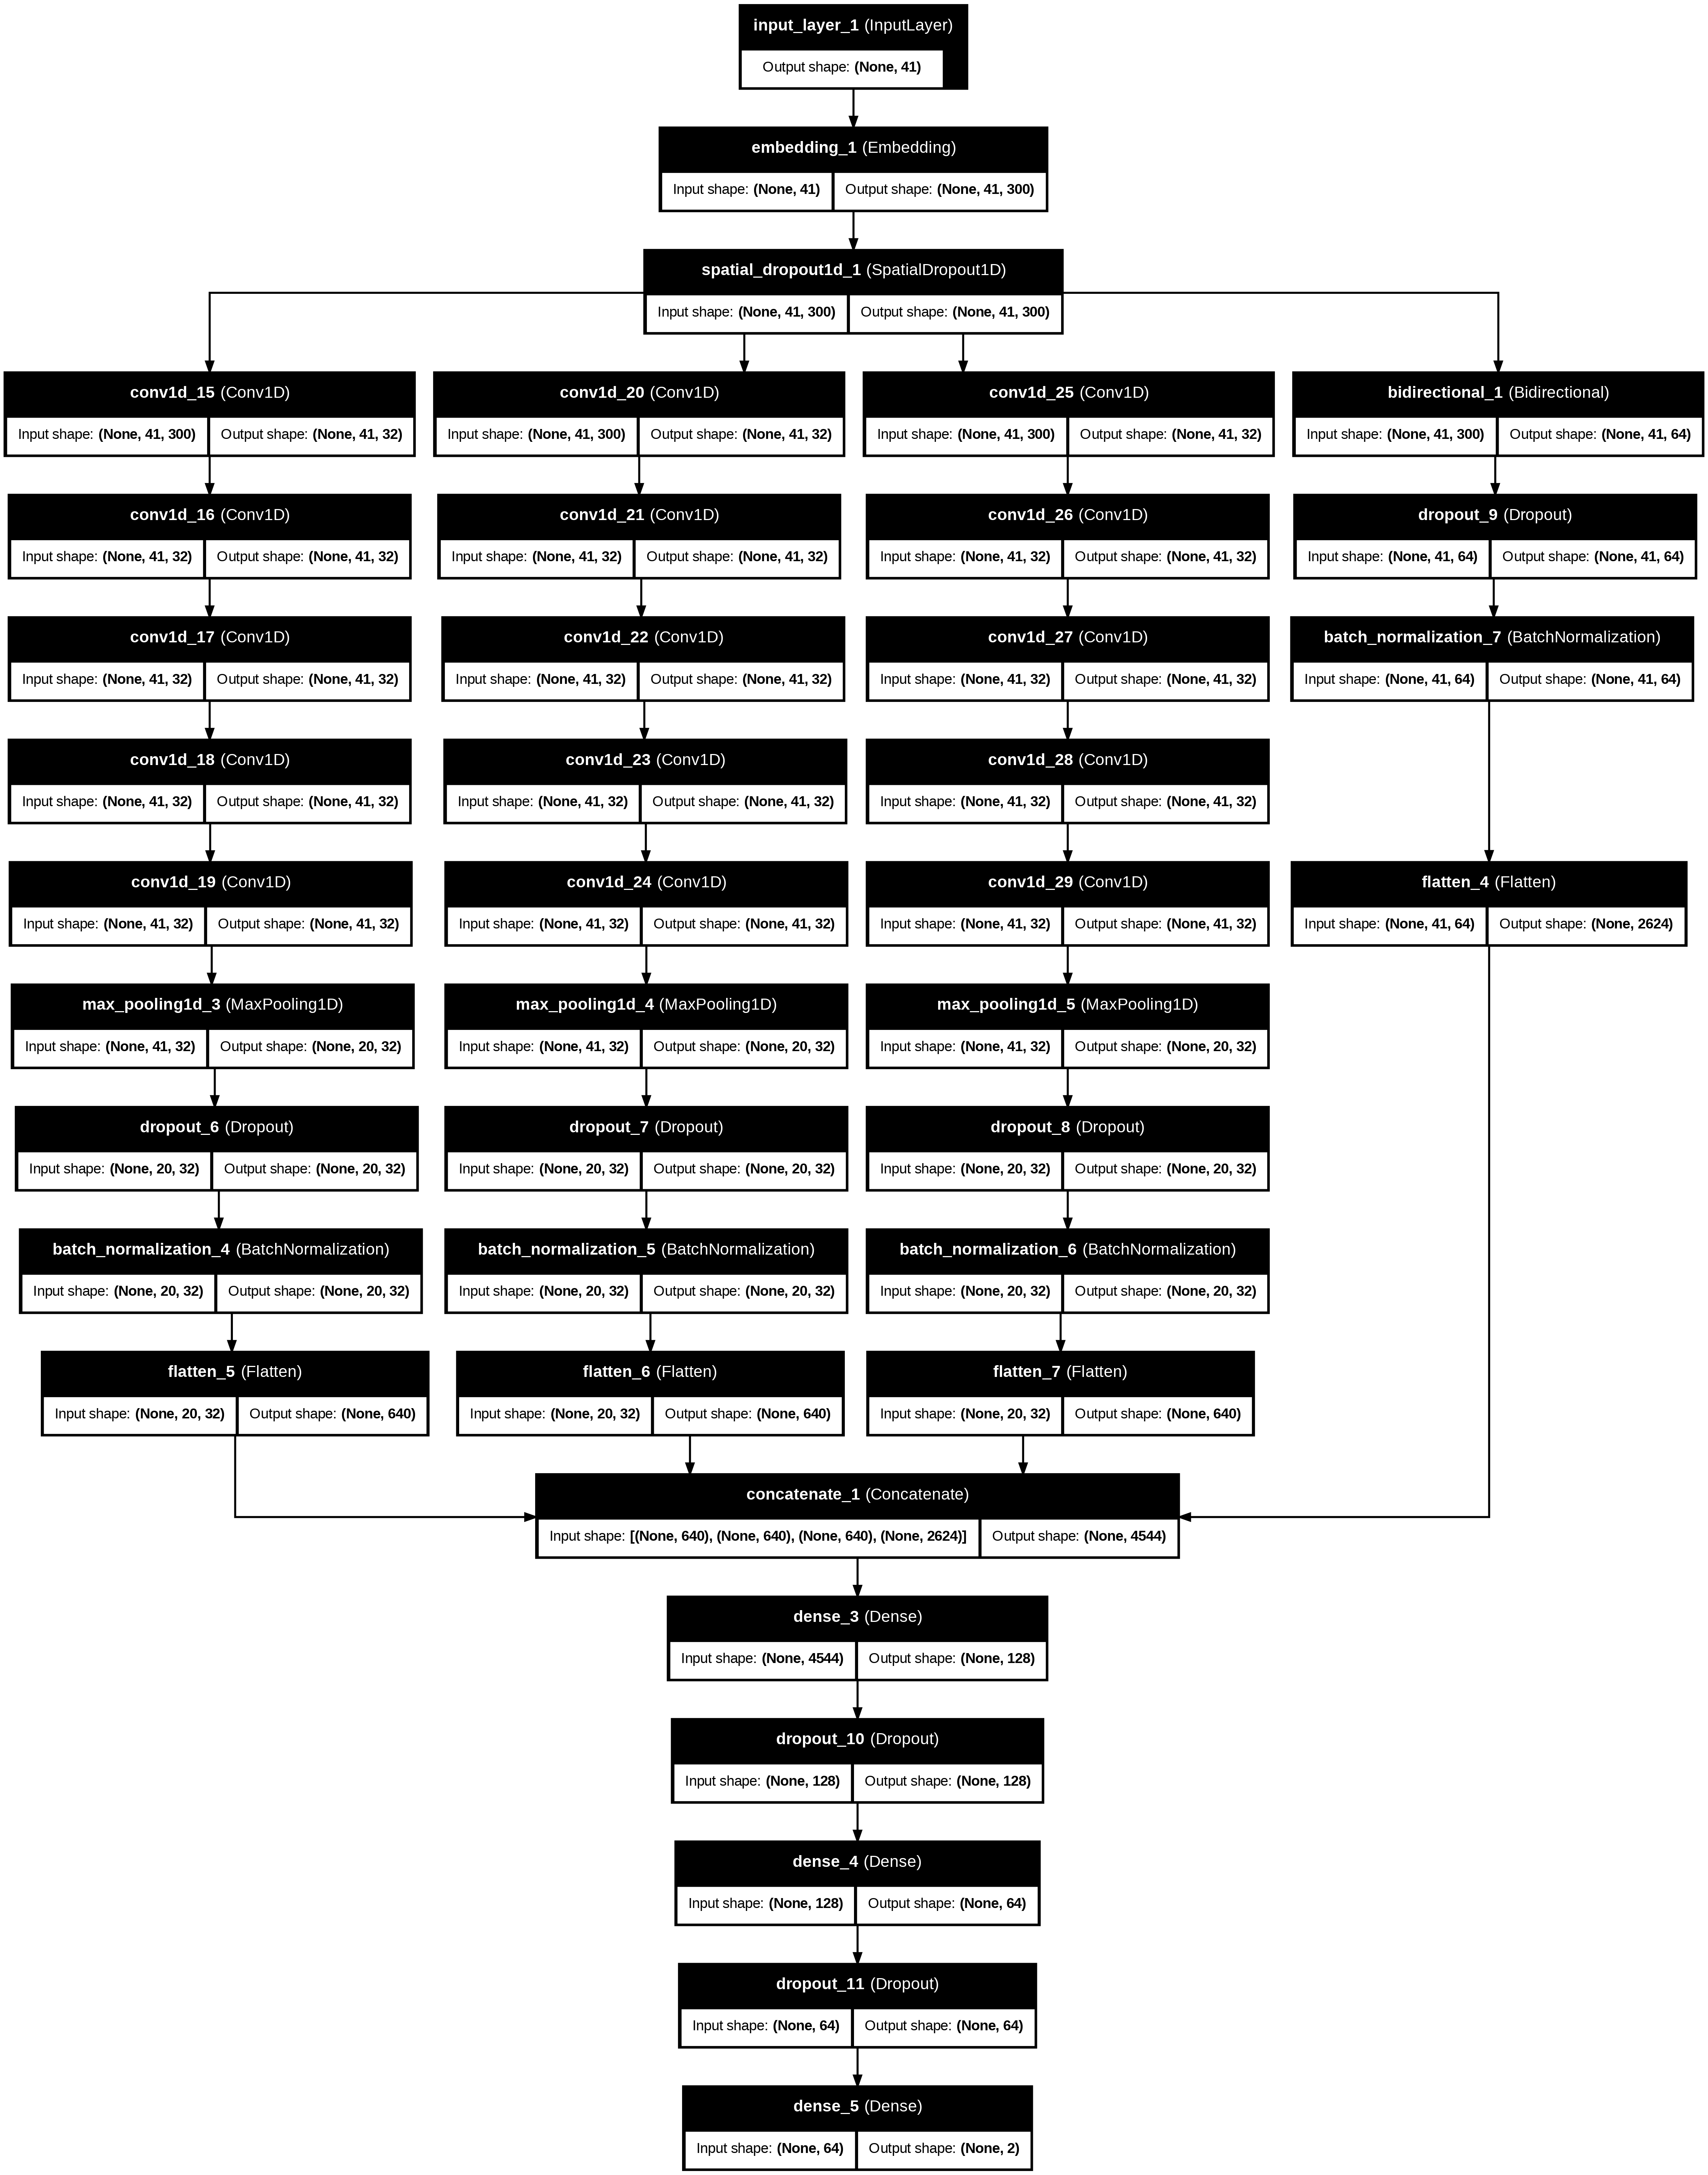

In [ ]:
from tensorflow.keras.utils import plot_model
# Lưu hình ảnh của mô hình
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

# Nếu muốn hiển thị trực tiếp trên notebook Jupyter
from IPython.display import Image
Image(filename='model_structure.png')

Training on fold 1/10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.6902 - loss: 3.6610
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7886 - loss: 2.6179
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8255 - loss: 1.9971
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8328 - loss: 1.5568
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8359 - loss: 1.2443
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8568 - loss: 1.0200
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8656 - loss: 0.8713
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8741 - loss: 0.8448
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9082 - loss: 0.7264
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9188 - loss: 0.6902
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9180 - loss: 0.6709
Epoch 12/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.6815 - loss: 3.6018
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7824 - loss: 2.5256
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8186 - loss: 1.8917
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8312 - loss: 1.4353
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8656 - loss: 1.1611
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8694 - loss: 0.9590
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8984 - loss: 0.8600
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9067 - loss: 0.7540
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9393 - loss: 0.6020
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9362 - loss: 0.5588
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9392 - loss: 0.5180
Epoch 12/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/ste

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step
Fold 2 - TP: 92, FP: 23, TN: 57, FN: 4
Training on fold 3/10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7103 - loss: 3.5645
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7829 - loss: 2.5461
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8232 - loss: 1.8998
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8407 - loss: 1.4631
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8457 - loss: 1.1762
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8652 - loss: 1.0204
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8822 - loss: 0.8677
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9034 - loss: 0.7571
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9172 - loss: 0.6863
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9178 - loss: 0.6691
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9389 - loss: 0.5928
Epoch 12/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/ste

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
Fold 3 - TP: 67, FP: 11, TN: 87, FN: 11
Training on fold 4/10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7007 - loss: 3.5019
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8036 - loss: 2.3504
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8091 - loss: 1.7910
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8210 - loss: 1.4310
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8523 - loss: 1.1022
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8503 - loss: 1.0275
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8861 - loss: 0.8743
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8883 - loss: 0.8311
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8781 - loss: 0.8085
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9011 - loss: 0.7499
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9136 - loss: 0.6839
Epoch 12/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7004 - loss: 3.6762
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7615 - loss: 2.7601
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7917 - loss: 2.0880
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8237 - loss: 1.6563
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8414 - loss: 1.3739
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8471 - loss: 1.1322
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8729 - loss: 0.9680
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8947 - loss: 0.8839
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9027 - loss: 0.7935
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9173 - loss: 0.7254
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9261 - loss: 0.6661
Epoch 12/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.6909 - loss: 3.5892
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7612 - loss: 2.5573
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7797 - loss: 1.9229
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8457 - loss: 1.4657
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8465 - loss: 1.1985
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8749 - loss: 1.0081
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8826 - loss: 0.8763
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8870 - loss: 0.8046
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9209 - loss: 0.7038
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9383 - loss: 0.6255
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9438 - loss: 0.5968
Epoch 12/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7063 - loss: 3.5135
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7796 - loss: 2.3722
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8299 - loss: 1.7749
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8204 - loss: 1.3990
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8540 - loss: 1.1315
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8725 - loss: 0.9010
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8841 - loss: 0.8138
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8905 - loss: 0.7521
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8979 - loss: 0.7252
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9223 - loss: 0.6542
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9312 - loss: 0.5775
Epoch 12/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.6936 - loss: 3.6760
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7829 - loss: 2.7410
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8188 - loss: 2.1122
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8372 - loss: 1.6342
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8653 - loss: 1.2746
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8722 - loss: 1.0954
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8679 - loss: 0.9643
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8989 - loss: 0.7849
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9160 - loss: 0.7244
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9216 - loss: 0.6434
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9466 - loss: 0.5961
Epoch 12/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7385 - loss: 3.5009
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7799 - loss: 2.5753
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7964 - loss: 2.0025
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8084 - loss: 1.5915
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8345 - loss: 1.2664
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8517 - loss: 1.0426
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8645 - loss: 0.9064
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8756 - loss: 0.8129
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9207 - loss: 0.6713
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9168 - loss: 0.6283
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9324 - loss: 0.6080
Epoch 12/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7067 - loss: 3.5447
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7915 - loss: 2.4207
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8185 - loss: 1.8192
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8295 - loss: 1.4248
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8621 - loss: 1.1077
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8691 - loss: 0.9235
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8740 - loss: 0.8568
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8618 - loss: 0.8059
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9095 - loss: 0.7099
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9100 - loss: 0.7173
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9212 - loss: 0.6142
Epoch 12/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/ste

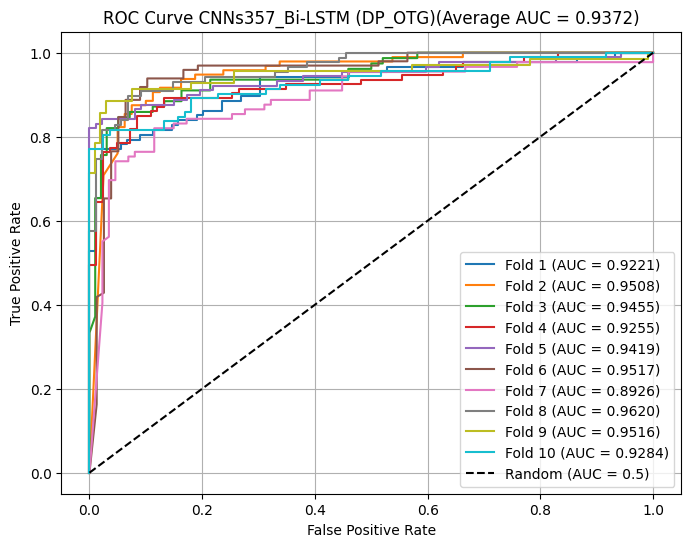

In [ ]:
# Cross-validation with AUC-ROC plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
from keras import models
from tensorflow.keras.callbacks import EarlyStopping

# Khởi tạo KFold với k=10
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Khởi tạo các biến lưu trữ kết quả cross-validation
all_metrics = []
confusion_matrices = []
all_auc_scores = []
best_auc = 0
best_model = None

plt.figure(figsize=(8, 6))

# Thực hiện K-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(Xtrain)):
    print(f"Training on fold {fold + 1}/{k}...")

    # Tạo dữ liệu train và validation cho fold hiện tại
    X_train_fold, X_val_fold = Xtrain[train_index], Xtrain[val_index]
    y_train_fold, y_val_fold = ytrain[train_index], ytrain[val_index]

    # Khởi tạo mô hình
    model = create_model(vocab_size, MAX_SEQUENCE_LENGTH)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Huấn luyện mô hình với EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train_fold, y_train_fold,
              epochs=100,
              batch_size=16,
              validation_data=(X_val_fold, y_val_fold),
              callbacks=[early_stopping],
              verbose=1)

    # Đánh giá trên tập validation
    results = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    all_metrics.append(results)

    # Dự đoán xác suất và phân loại nhãn
    y_pred_probs = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_val_fold, axis=1)

    # Tính confusion matrix và lưu TP, FP, TN, FN
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    tn, fp, fn, tp = cm.ravel()
    confusion_matrices.append({"Fold": fold + 1, "TP": tp, "FP": fp, "TN": tn, "FN": fn})

    print(f"Fold {fold + 1} - TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

    # Tính toán đường cong ROC-AUC
    fpr, tpr, _ = roc_curve(y_true_classes, y_pred_probs[:, 1])
    auc_score = auc(fpr, tpr)
    all_auc_scores.append({"Fold": fold + 1, "AUC": auc_score})

    # Vẽ đường cong ROC cho từng fold
    plt.plot(fpr, tpr, label=f"Fold {fold + 1} (AUC = {auc_score:.4f})")

    # Cập nhật mô hình tốt nhất
    if auc_score > best_auc:
        best_auc = auc_score
        best_model = model

# Lưu mô hình tốt nhất
if best_model:
    best_model.save(path_result + "DP_OTG.h5")
    print("\nBest model saved as 'DP_OTG.h5'")

# Tính trung bình kết quả từ các fold
avg_metrics = np.mean(all_metrics, axis=0)
avg_auc = np.mean([auc_info["AUC"] for auc_info in all_auc_scores])

print(f"\nAverage Metrics over {k}-Fold Cross Validation:")
for metric_name, avg_metric in zip(model.metrics_names, avg_metrics):
    print(f"{metric_name}: {avg_metric:.4f}")

print(f"\nAverage AUC-ROC: {avg_auc:.4f}")

# Lưu kết quả AUC, TP, FP, TN, FN vào file Excel
df_confusion = pd.DataFrame(confusion_matrices)
df_auc = pd.DataFrame(all_auc_scores)

# Ghi cả hai bảng vào một file Excel
with pd.ExcelWriter(path_result + "cv_CNNs357_Bi-LSTM5.xlsx") as writer:
    df_confusion.to_excel(writer, sheet_name="Confusion Matrix", index=False)
    df_auc.to_excel(writer, sheet_name="AUC Scores", index=False)

print("\nResults saved to 'cv_CNNs357_Bi-LSTM5.xlsx'")

# Hoàn thiện và hiển thị đường cong AUC-ROC tổng hợp
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve CNNs357_Bi-LSTM (DP_OTG) (Avg AUC = {avg_auc:.4f})')
plt.legend()
plt.grid()
plt.show()
